In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import os
import sys
cwd = os.getcwd()
parent_dir = os.path.abspath(os.path.join(cwd, os.pardir))
sys.path.insert(0, os.path.join(parent_dir, 'pysta2'))

import pysta
# import stc
# import stcl

# from stcl import load_centers

import pandas as pd
import os

%load_ext autoreload
%autoreload 2

In [2]:
# helper functions for visualization
def box_off():
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
def p2p(sta):
    return np.max(sta) - np.min(sta)

def psnr(sta):
    return (np.max(sta.ravel()) - np.min(sta.ravel())) / np.std(sta.ravel())

def plot_spatio_temporal(sta, height=13, width=13, dt=1000/30, ylabel=None, fig_basename=None):        
    tap = sta.shape[-1]
    figsize = (5.5,3.5)
    plt.figure(figsize=figsize)
    pysta.plot_temporal_profile(sta, tap, dt, ylim=[-0.5,0.5])
    if ylabel is not None:
        plt.ylabel(ylabel)
    print('peak-to-peak diff. = {:.2f}'.format(p2p(sta)))
    print('PSNR = {:.2f}'.format(psnr(sta)))
#     plt.title('peak diff. = {:.2f}'.format(p2p(sta)))
    plt.xlabel(None)

    if fig_basename is not None:
        plt.savefig(fig_basename + '_temp.pdf', bbox_inches='tight') # https://stackoverflow.com/a/4046233

    plt.figure()
    pysta.plot_stim_slices(sta, height=height, width=width, dt=dt, vmin=-0.5, vmax=0.5)

#     plt.tight_layout()
    
    if fig_basename is not None:
        plt.savefig(fig_basename + '_spatial.pdf', bbox_inches='tight')
    
    
def groupby_dict(df, col, group):
    data = dict()
    for group_val, d in df.groupby(group):
#         print(group_val)
        data[group_val] = d[col].to_list()
    return data



    

def plot_bar_by_group(info, col, 
                      groupby='cell_type', 
                      group_values = None, color=None):
                      #group_values = ['ON', 'OFF', 'ON-OFF', 'Unknown'], color=['r','#00A0FF','green', '#A0A0A0']):
        
    if group_values is None:
        if len(info[groupby].value_counts()) == 3: # ON, OFF, Unknown
            group_values = ['ON', 'OFF', 'Unknown']
            color = ['r','#00A0FF', '#A0A0A0']
        elif len(info[groupby].value_counts()) == 4: # ON, OFF, ON-OFF, Unknown
            group_values = ['ON', 'OFF', 'ON-OFF', 'Unknown']
            color = ['r','#00A0FF','green', '#A0A0A0']          
    
    means = info.groupby(groupby)[col].mean()[group_values]
    sems = info.groupby(groupby)[col].sem()[group_values]

    plt.bar(group_values, means, yerr=sems,
            width=0.4, color=color, edgecolor='k', linewidth=1,
            capsize=5)
    
    plt.ylabel(col.replace('_', ' '))
    plt.xlabel(groupby.replace('_', ' '))
    
    plt.xlim(-0.5, len(group_values)-0.5)
    box_off()

Let's re-plot old Figure 3 (ON-OFF cell) for all the methods

## load data

In [3]:
# baseline dataset
dataset0 = '8x8 10Hz'

width = 8
height = 8
fps = 10

info0 = pd.read_csv('20180828_{}pix_{}Hz_sta.csv'.format(width,fps))
info0['dataset'] = dataset0

In [4]:
# # different spatial & temporal resolutions (2018.08.28)
# dataset1 = '8x8 25Hz'

# width = 8
# height = 8
# fps = 25

# dataset1 = '13x13 10Hz'

# width = 13
# height = 13
# fps = 10

dataset1 = '26x26 10Hz'

width = 26
height = 26
fps = 10

info1 = pd.read_csv('20180828_{}pix_{}Hz_sta.csv'.format(width,fps))
info1['dataset'] = dataset1

info = pd.concat([info0, info1])

In [5]:
# compare with gaussian stim
dataset1 = 'contrast100'

width = 8
height = 8
fps = 10

info1 = pd.read_csv(dataset1+'_sta.csv')
info1['dataset'] = dataset1

info = pd.concat([info0, info1])

## compare STA p2p

In [6]:
info.groupby('dataset').mean()[['sta_p2p', 'sta_psnr']]

,sta_p2p,sta_psnr
dataset,,
8x8 10Hz,0.336359,12.408469
contrast100,0.158403,14.312625


In [7]:
# info.groupby('dataset').sem()[['sta_p2p', 'sta_psnr']]

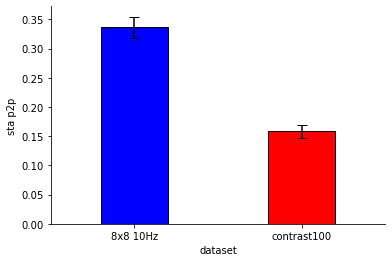

In [8]:
plot_bar_by_group(info, 'sta_p2p',
                  groupby='dataset',
                  group_values = [dataset0, dataset1], color=['b', 'r'])

In [9]:
# test significance: ON or OFF vs. ON/OFF
data = groupby_dict(info, 'sta_p2p', 'dataset')

t, p = stats.ttest_ind(data[dataset0], data[dataset1], equal_var=False)
print(p)

3.519735367800929e-14


## Compare by cell types

In [10]:
info.groupby(['dataset','cell_type'], sort=False).mean()

sta_p2p   sta_psnr  number of spikes   sta std  \
dataset     cell_type                                                    
8x8 10Hz    OFF        0.372672  17.239014               NaN       NaN   
            ON         0.421244  15.778832               NaN       NaN   
            Unknown    0.265957   7.192651               NaN       NaN   
contrast100 ON-OFF     0.107317  13.877413      16609.382353  0.007116   
            ON         0.177489  14.030017       8980.523810  0.011152   
            OFF        0.179539  17.052015      14488.588235  0.009704   
            Unknown    0.202710  12.781634       5303.846154  0.013991   

                        sta max   sta min  
dataset     cell_type                      
8x8 10Hz    OFF             NaN       NaN  
            ON              NaN       NaN  
            Unknown         NaN       NaN  
contrast100 ON-OFF     0.569409  0.462052  
            ON         0.620176  0.442516  
            OFF        0.613810  0.434200  
            Unknown    0.629886  0.426120

In [11]:
# info.groupby(['dataset','cell_type'], sort=False).sem()

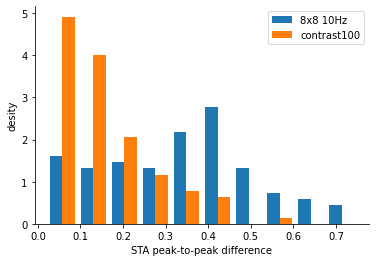

In [12]:
col = 'sta_p2p'
plt.hist([info0[col].tolist(), info1[col].tolist()], density=True)
plt.legend([dataset0, dataset1])
plt.xlabel('STA peak-to-peak difference')
plt.ylabel('desity')
box_off()

Text(0.5, 1.0, '8x8 10Hz')

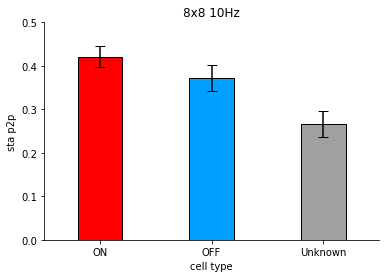

In [15]:
plot_bar_by_group(info0, 'sta_p2p')

plt.ylim(0, 0.5)
plt.title(dataset0)
# plt.savefig("figure/sta/{}_p2p_bar.pdf".format(dataset), bbox_inches='tight')
# plt.savefig("figure/sta/{}_p2p_bar.png".format(dataset), bbox_inches='tight')

In [16]:
# test significance: ON or OFF vs. ON/OFF
data = groupby_dict(info0, 'sta_p2p', 'cell_type')

t, p = stats.ttest_ind(data['ON'], data['OFF'], equal_var=False)
print(p)

t, p = stats.ttest_ind(data['ON'] + data['OFF'], data['Unknown'], equal_var=False)
print(p)

0.21517341518832314
0.0006173642310534859


Text(0.5, 1.0, 'contrast100')

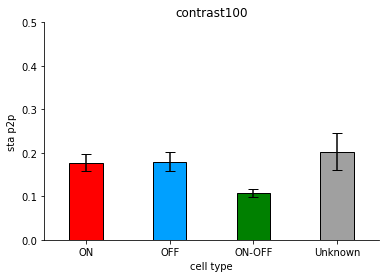

In [17]:
plot_bar_by_group(info1, 'sta_p2p')

plt.ylim(0, 0.5)
plt.title(dataset1)
# plt.savefig("figure/sta/{}_p2p_bar.pdf".format(dataset), bbox_inches='tight')
# plt.savefig("figure/sta/{}_p2p_bar.png".format(dataset), bbox_inches='tight')

In [18]:
# test significance: ON or OFF vs. ON/OFF
data = groupby_dict(info1, 'sta_p2p', 'cell_type')

t, p = stats.ttest_ind(data['ON'], data['OFF'], equal_var=False)
print(p)

t, p = stats.ttest_ind(data['ON'] + data['OFF'], data['Unknown'], equal_var=False)
print(p)

0.9439356418103431
0.5921266005632457


In [19]:
t, p = stats.ttest_ind(data['ON'] + data['OFF'], data['ON-OFF'], equal_var=False)
print(p)

0.00011017035401069673


## Compare with `PSNR`

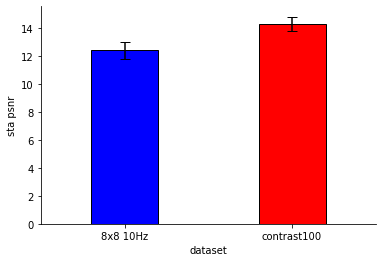

In [23]:
plot_bar_by_group(info, 'sta_psnr',
                  groupby='dataset',
                  group_values = [dataset0, dataset1], color=['b', 'r'])

In [24]:
# test significance: ON or OFF vs. ON/OFF
data = groupby_dict(info, 'sta_psnr', 'dataset')

t, p = stats.ttest_ind(data[dataset0], data[dataset1], equal_var=False)
print(p)

0.01496037845182301


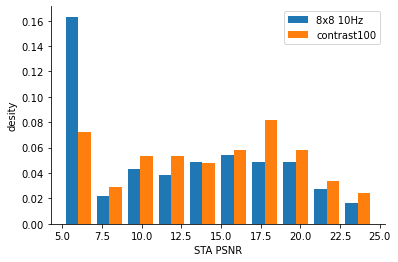

In [22]:
col = 'sta_psnr'
plt.hist([info0[col].tolist(), info1[col].tolist()], density=True)
plt.legend([dataset0, dataset1])
plt.xlabel('STA PSNR')
plt.ylabel('desity')
box_off()

Text(0.5, 1.0, '8x8 10Hz')

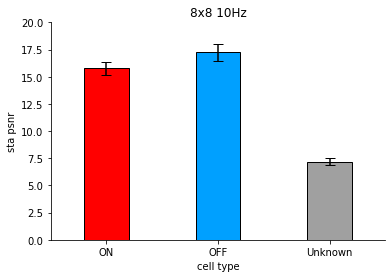

In [28]:
plot_bar_by_group(info0, 'sta_psnr')

plt.ylim(0, 20)
plt.title(dataset0)
# plt.savefig("figure/sta/{}_p2p_bar.pdf".format(dataset), bbox_inches='tight')
# plt.savefig("figure/sta/{}_p2p_bar.png".format(dataset), bbox_inches='tight')

Text(0.5, 1.0, 'contrast100')

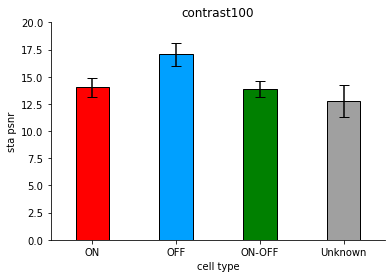

In [30]:
plot_bar_by_group(info1, 'sta_psnr')

plt.ylim(0, 20)
plt.title(dataset1)
# plt.savefig("figure/sta/{}_p2p_bar.pdf".format(dataset), bbox_inches='tight')
# plt.savefig("figure/sta/{}_p2p_bar.png".format(dataset), bbox_inches='tight')